# Comparing distributions

We want to extract the (sytle) distribution for the whole corpus and the specific artist's corpus.
We then compare these distributions and check which ones are more similar to the base corpus distribution.


In [1]:
import pandas as pd
#df = pd.read_parquet('sources/metadata.parquet', engine='pyarrow')
#df_large = pd.read_parquet('sources/metadata-large.parquet', engine='pyarrow')

exact_matches = pd.read_parquet("../results/artists_exact_match_large.parquet", engine='pyarrow')
assert "artists" in exact_matches.columns, f'artists is not in {exact_matches.columns}'
assert "num_artists" in exact_matches.columns, f'num_artists is not in {exact_matches.columns}'

print(f'exact match shapes {exact_matches.shape}')

# read excel_artist_names
import my_utils

#excel_artist_names = my_utils.read_lines_as_list("../sources/excel_artists_copy_paste_name.txt")
#hundred_artist_names = excel_artist_names[0:100]
#ten_artist_names = excel_artist_names[0:10]


artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')
artist_mentions.sort_values(["mentions"], inplace=True, ascending=False)

exact match shapes (1819808, 7)


In [2]:
from collections import defaultdict
import numpy as np
import math

def extract_style_counts(df):
    counts = defaultdict(lambda: 0)
    total = 0
    for i, row in df.iterrows():
        for style in row.styles:
            counts[style]=counts[style]+1
            total=total + 1
    return total, counts

def visualize_dissimilarity_computation(dissimilarity, share_artist, share_other, artist_name, savename, num_styles=0):
    
    import matplotlib.pyplot as plt
    
    if num_styles == 0:
        labels = list(share_other.keys())
    else:
        style_df = pd.read_parquet('../results/style_mentions.parquet', engine='pyarrow')
        style_df.sort_values("mentions", ascending=False, inplace=True)
        labels = list(style_df.head(num_styles)["style"].values)
        
    
    

    artist = [share_artist[x] for x in labels]
    other = [share_other[x] for x in labels]
    common = [min(share_artist[x], share_other[x]) for x in labels]
    
    if num_styles < len(share_other.keys()):
        remaining_share_artist, remaining_share_other, remaining_share_common = 0, 0, 0

        for x in share_other.keys():
            if x not in labels:
                remaining_share_artist = remaining_share_artist + share_artist[x]
                remaining_share_other = remaining_share_other + share_other[x]
                remaining_share_common = remaining_share_common + min(share_artist[x], share_other[x])
        artist.append(remaining_share_artist)
        other.append(remaining_share_other)
        common.append(remaining_share_common)

        labels.append("remaining styles")

    N = len(labels)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind-width, artist, width, color='royalblue')
    
    rects2 = ax.bar(ind, other, width, color='seagreen')
    rects3 = ax.bar(ind+width, common, width, color='red')

    # add some
    ax.set_ylabel(f'Shares')
    ax.set_title(f'Dissimilarity computation {round(dissimilarity, 3)} for {artist_name}')
    ax.set_xticks(ind) # + width / 2)
    ax.set_xticklabels( labels , rotation=90)

    ax.legend( (rects1[0], rects2[0], rects3[0]), ('Artist', 'Other', 'Common') )
    plt.savefig(savename)

    plt.show()
    
def bc_dissimilarity(share_artist, share_other):
    similarity_sum = 0
    for key, value in share_other.items():
        similarity_sum = similarity_sum + min(share_artist[key], share_other[key])
        # adds the amount of common share to the similarity_sum
    
    return 1 - similarity_sum
    

<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_189999/2926903325.py:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_styles is 0:


                Digital art   Realism  Art Nouveau  Romanticism  Hyperrealism  \
Greg Rutkowski     0.370453  0.201593     0.046362     0.051683      0.054225   

                Surrealism   Baroque  Futurism  Magic realism  Graffiti  ...  \
Greg Rutkowski    0.032577  0.041697  0.016223       0.000393   0.01887  ...   

                Feminist art  Neo-Dada  Verdadism  Neo-romanticism  \
Greg Rutkowski           0.0       0.0        0.0              0.0   

                Cubo-Futurism  Neo-primitivism  Heidelberg School  \
Greg Rutkowski            0.0              0.0                0.0   

                Neo-expressionism  Mail art  Art Informel  
Greg Rutkowski                0.0       0.0           0.0  

[1 rows x 185 columns]


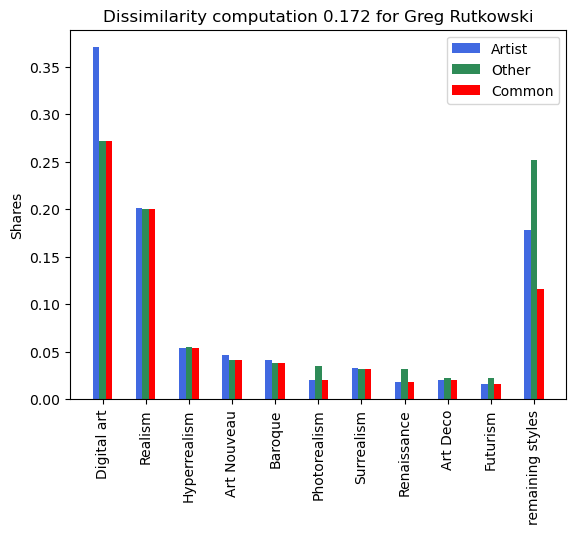

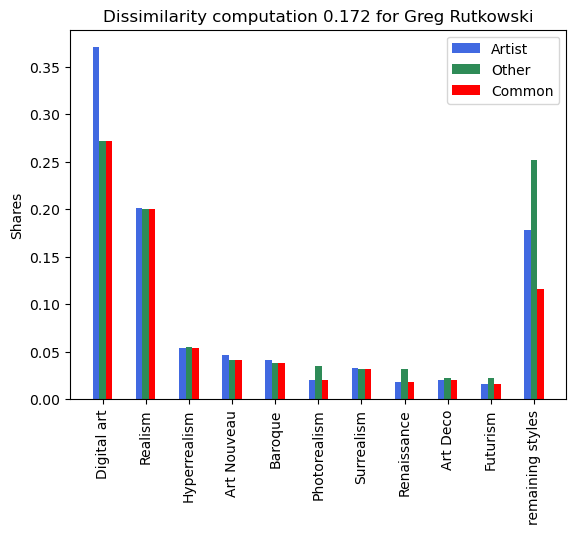

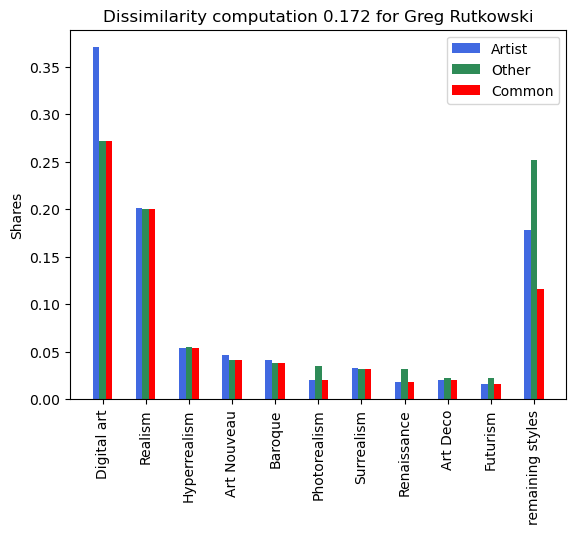

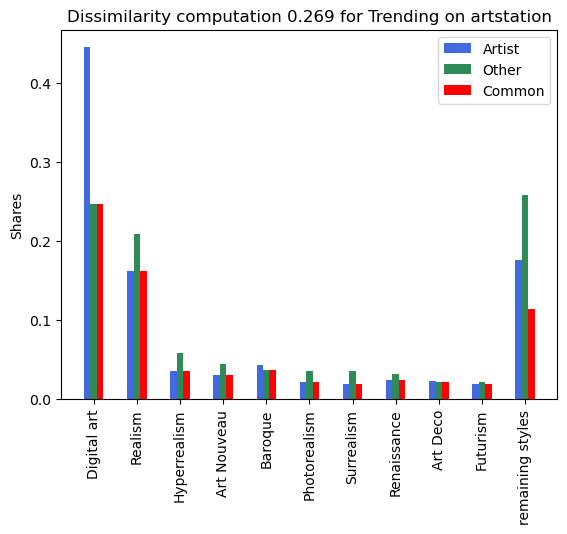

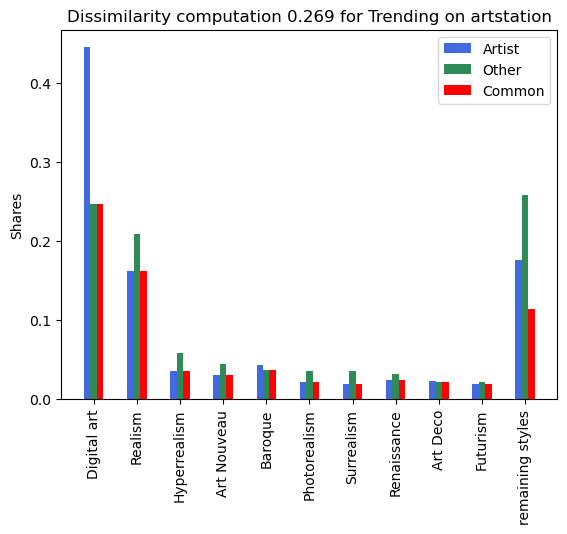

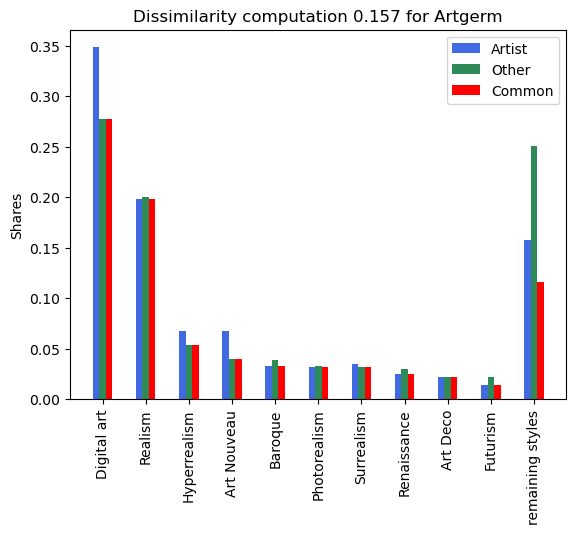

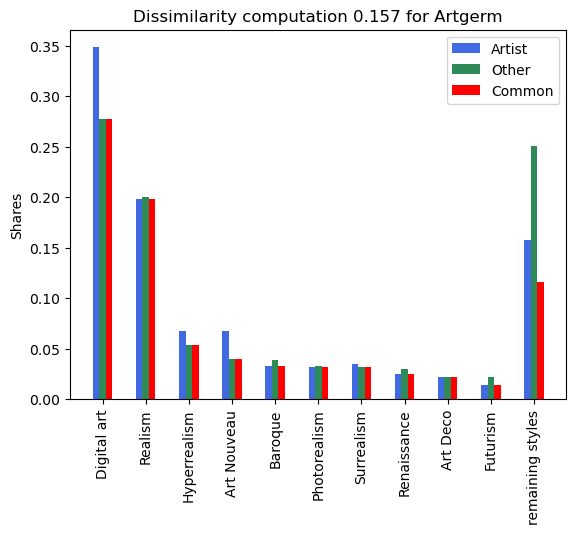

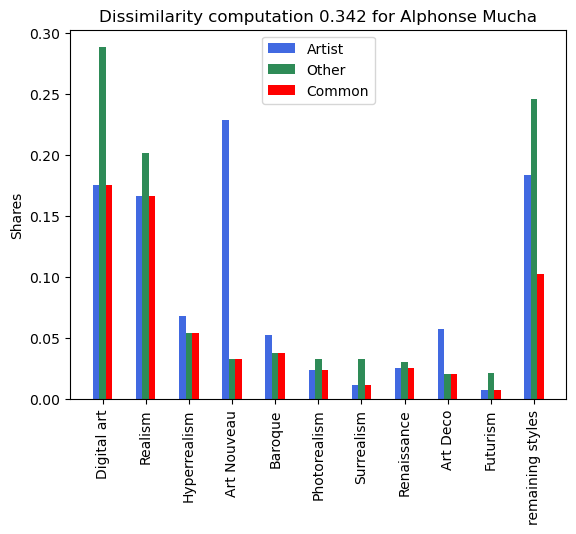

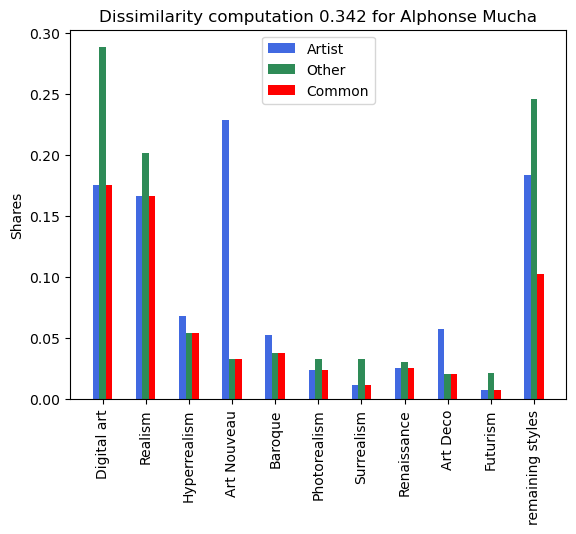

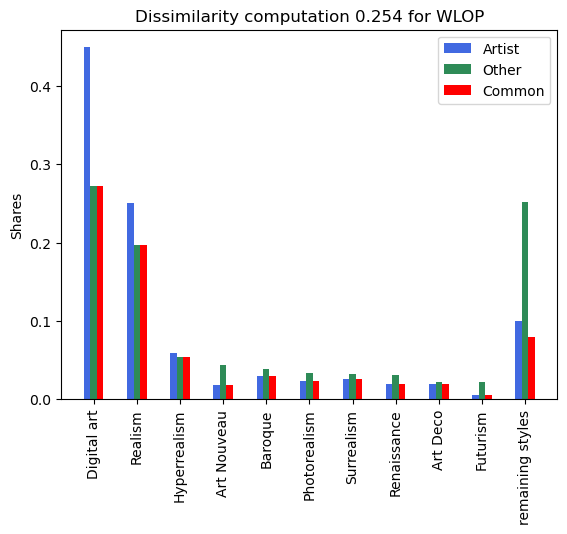

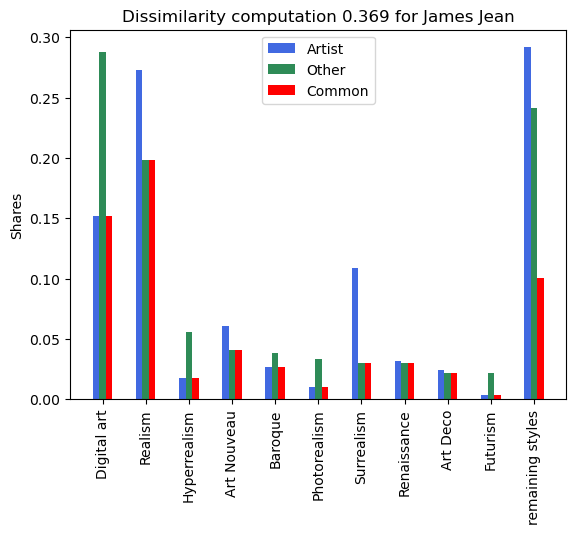

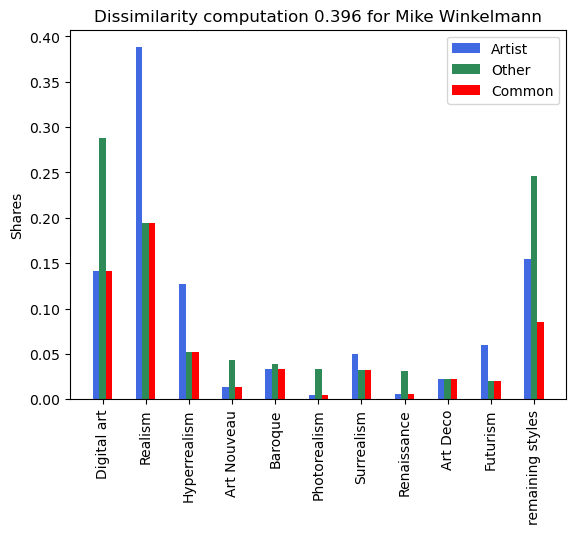

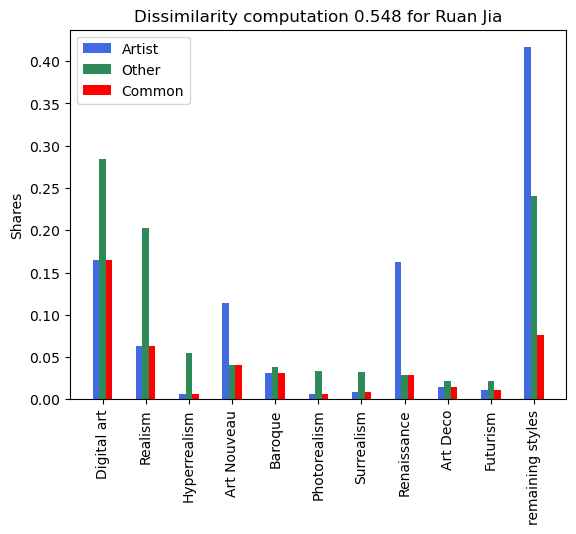

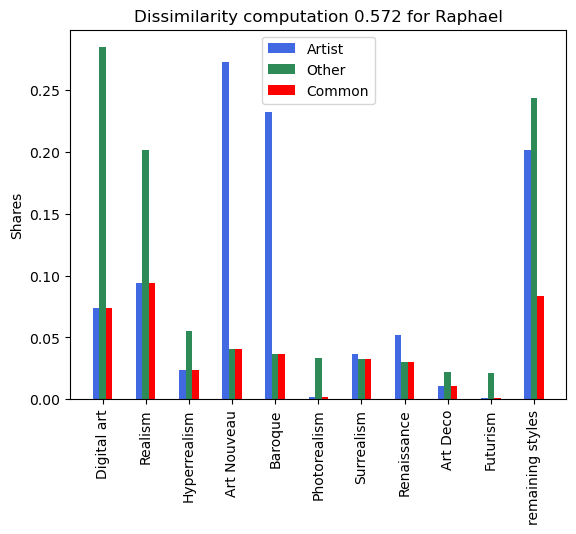

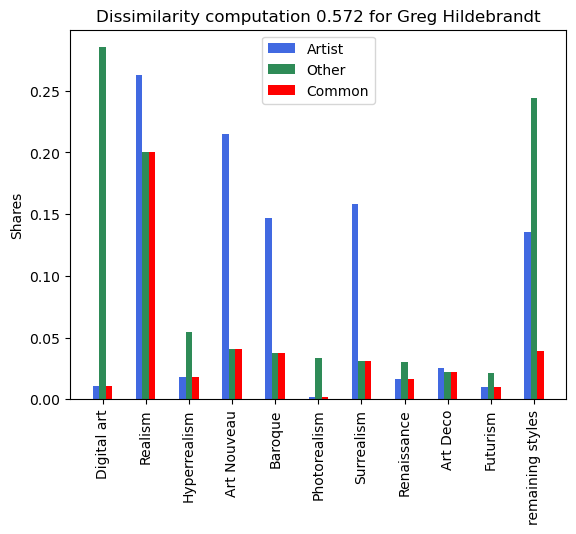

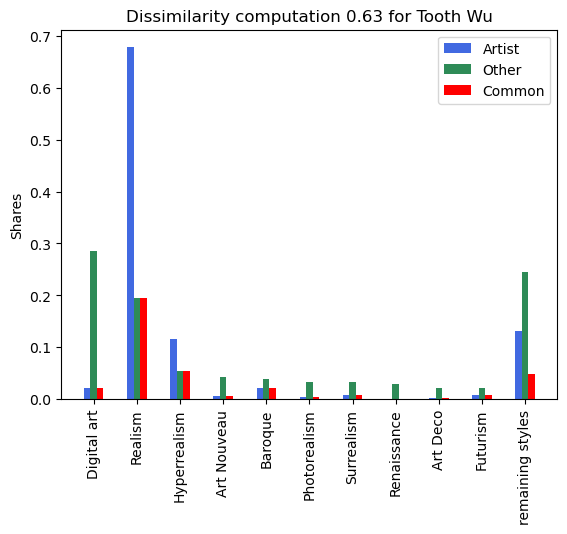

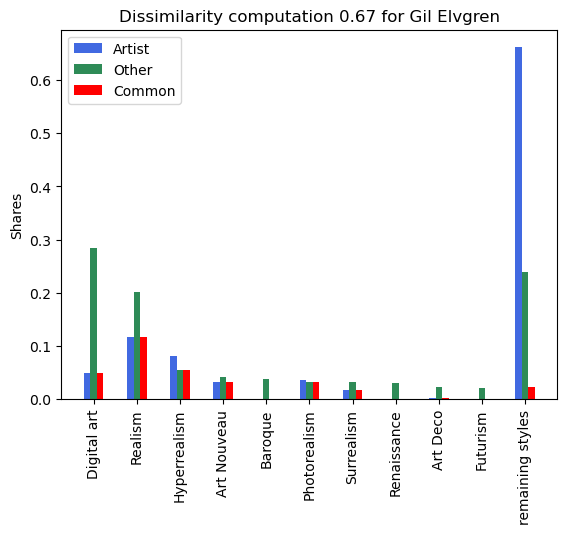

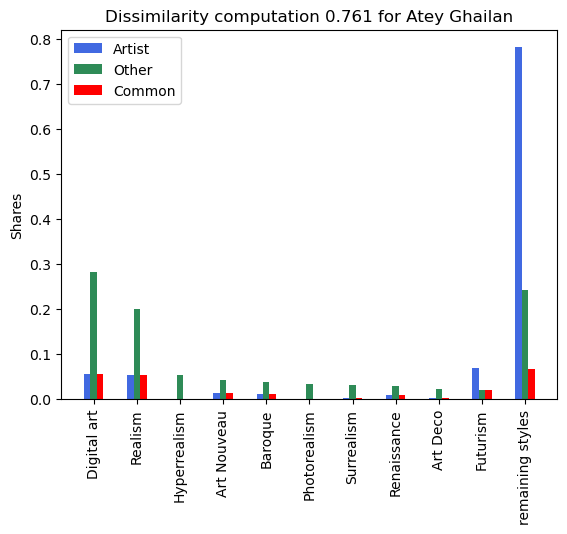

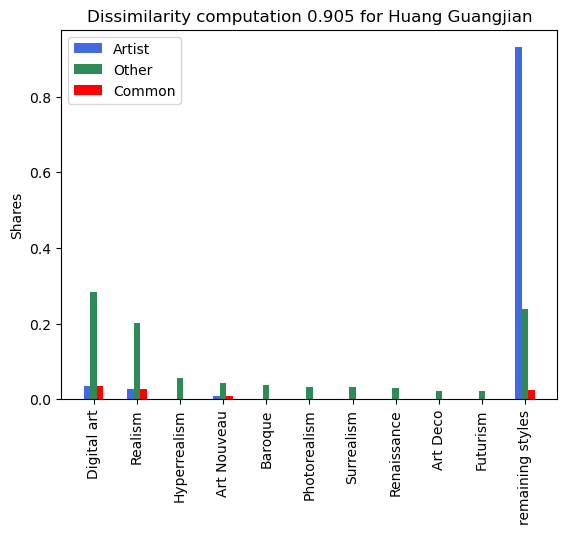

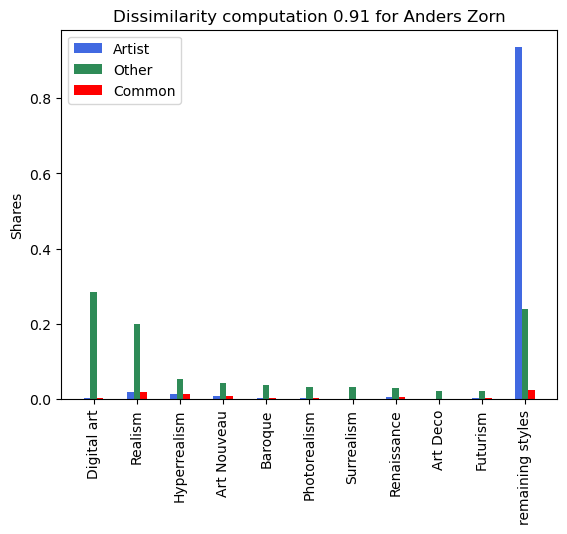

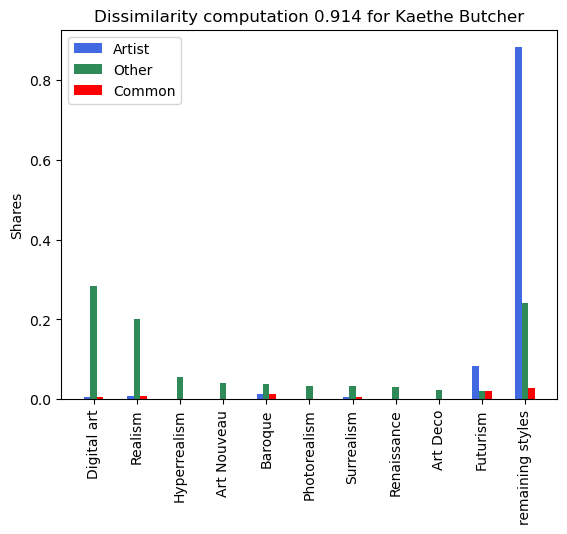

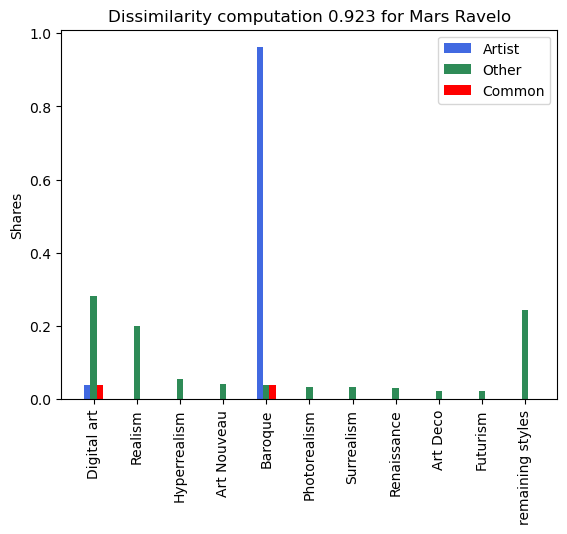

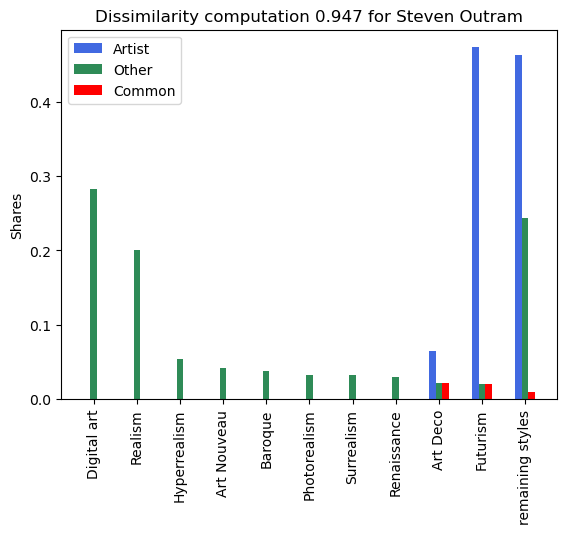

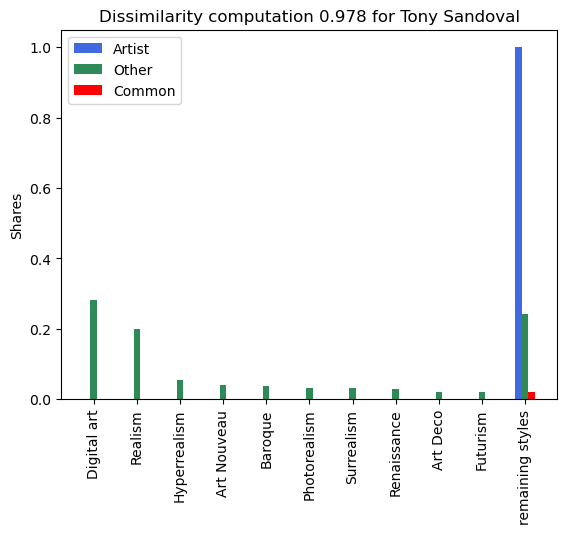

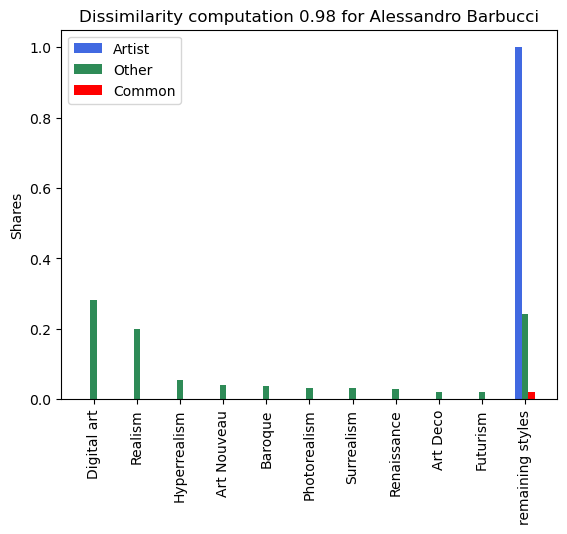

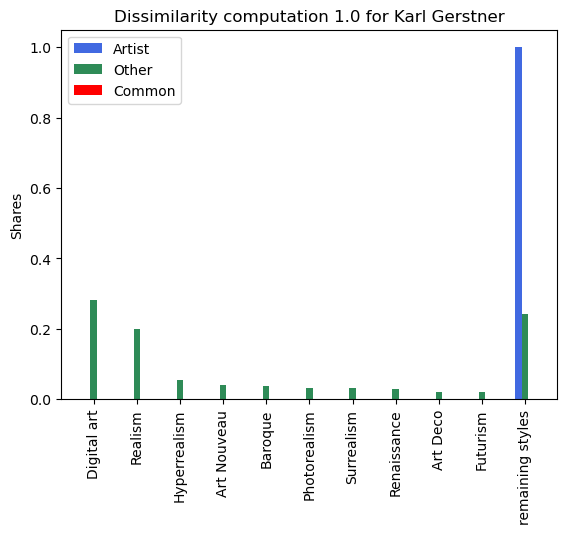

In [ ]:
import pandas as pd
import my_utils
import time
import copy
import matplotlib.pyplot as plt


artists = artist_mentions.artist.values

total_all, counts_all = extract_style_counts(exact_matches)

dissimilarities = {}
ineligible_artists=[]

lowest_dissimilarity = 1
highest_dissimilarity = 0

share_df = pd.DataFrame(columns=list(counts_all.keys()))
for index, artist in enumerate(artists):
    
    artist_df = my_utils.exact_match_dataframe(exact_matches, artist)
    
    if artist_df.shape[0] == 0:
        ineligible_artists.append(artist)
        #print(f'{artist} was not mentioned at all')
        continue
    
    assert artist_df.shape[0]>0, f'no match found for {artist}'
    total_artist, counts_artist = extract_style_counts(artist_df)
    
    if total_artist == 0:
        ineligible_artists.append(artist)
        #print(f'{artist} had no mention of any styles')
        continue
    
    total_other = total_all - total_artist
    counts_other = copy.deepcopy(counts_all) # counts_other are the style mentions in (all prompts - artist_df)
    for key, value in counts_other.items():
        assert value > 0, f'value must be bigger than 0 since we go over all prompts, word {key}'
        assert counts_other[key] >= counts_artist[key], f'counts of {key} in entire should be higher or equal to specific, {counts_other[key]} {counts_artist[key]}'
        assert key in counts_artist.keys()
        assert len(counts_artist.keys()) <= len(counts_other.keys())
        counts_other[key] = counts_other[key] - counts_artist[key]
        
    
    
    share_artist = copy.deepcopy(counts_artist) # share the counts make up of all style mentions
    for key, value in share_artist.items():
        share_artist[key]  = value / total_artist
        
    share_other = copy.deepcopy(counts_other) # share the counts make up of all style mentions
    for key, value in share_other.items():
        share_other[key]  = value / total_other
                
    s = pd.Series(share_artist, index=share_df.columns, name=artist)
  
    transpose = s.to_frame().T
    if index == 0:
        print(transpose)
    share_df =  pd.concat([share_df, transpose])
    
    dissimilarities[artist] = bc_dissimilarity(share_artist, share_other)
    
    if index < 5:
        savename=f'../images/{artist}_style_proportions.png'
        visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_other, artist, savename, 10)
        
    if dissimilarities[artist] < lowest_dissimilarity:
        lowest_dissimilarity = dissimilarities[artist]
        savename=f'../images/artist_lowest_dissimilarity.png'
        visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_other, artist, savename, 10)
        
        
    if dissimilarities[artist] > highest_dissimilarity:
        highest_dissimilarity = dissimilarities[artist]
        savename=f'../images/artist_highest_dissimilarity.png'
        visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_other, artist, savename, 10)
        
        
        
    
    
share_all = copy.deepcopy(counts_all) # share the counts make up of all style mentions
for key, value in share_all.items():
    share_all[key]  = value / total_all

share_df["dissimilarity"] = dissimilarities    
    
share_df = pd.concat([share_df, pd.Series(share_all, index=share_df.columns, name="overall_dataset").to_frame().T])

# print(f'all dissimilarities {dissimilarities}')
print(f'dissimilarity of greg: {dissimilarities["Greg Rutkowski"]}')
print(share_df.head())

print(f'a total of {len(ineligible_artists)} artists were not eligible for the artist characterization by style.')

share_df.to_parquet("../results/artists_style_mention_proportions.parquet")
share_df.to_csv("../results/artists_style_mention_proportions.csv", escapechar="\\")



In [ ]:
#print(dissimilarities)

In [ ]:
print(f'a total of {len(ineligible_artists)} artists were not elibilbe for the comparison since they were either not mentioned in any prompts or their associated prompts had no style mentions')
#print(f'ineligible artists: {ineligible_artists})

ineligible_filename = "../results/ineligible_artists.txt"
with open(ineligible_filename, "w") as file:
    for ia in ineligible_artists:
        file.write(f'{ia}\n')
print(f'ineligible artists saved to {ineligible_filename}')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

share_df = pd.read_parquet("../results/artists_style_mention_proportions.parquet", engine='pyarrow')

print(share_df.columns)

x_data = share_df.index
y_data = [x[1]["dissimilarity"] for x in share_df.iterrows()]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_data, y_data, s=1)
#ax.plot(x_data, y_data) # we cannot plot like this since the image would be extremely cluttered

ax.set_xlabel('Artists ordered by Rank')
ax.set_xticklabels( x_data , rotation=90)
ax.set_ylabel('Dissimilarity')
ax.set_title('Artist dissimilarities')

every_nth = 100
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig("../images/ranked_artist_dissimilarity.png")

plt.show()

In [ ]:
print(f'dissimilarity described')
print(share_df.dissimilarity.describe())

# Spearman Correlation of Artist Rank and dissimilarity

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

def get_dissimilarity(artist):
    if artist in share_df.index:
        #print(f'{share_df.loc[[artist]].dissimilarity.item()} dissim of {artist}')
        return share_df.loc[[artist]].dissimilarity.item()
    else: 
        #print(f'other {artist}')
        return -1

#rho = share_df.corr()
#pval = share_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

# join artist mentions with the dissimilarity values for the correlation analysis

share_df = pd.read_parquet("../results/artists_style_mention_proportions.parquet", engine='pyarrow')
#print(share_df.head())

artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')
artist_mentions.sort_values(["mentions"], inplace=True, ascending=False)

#for inde, row in artist_mentions.iterrows():
#    print(f'row index {row.index}')
#    row['dissimilarity'] = 1

#for index, row in artist_mentions.iterrows():
#    print(row)

artist_mentions['dissimilarity'] = artist_mentions.artist.apply(lambda x: get_dissimilarity(x))

print(share_df.head())
print(artist_mentions.head())

print(artist_mentions[["mentions", "dissimilarity"]].head())

result = spearmanr(artist_mentions[["mentions", "dissimilarity"]])
print(result)
                                                                                      
print(result.pvalue)